This notebook includes:
1. Dataset download from Kaggle
2. Model training
3. Real-time recognition (webcam + images)


In [1]:
# ============================================================================
# CELL 1: Setup and Install Dependencies
# ============================================================================

print("📦 Installing required packages...")

!pip install -q tensorflow numpy pandas opencv-python matplotlib seaborn scikit-learn kaggle

print("✅ All packages installed!")


📦 Installing required packages...
✅ All packages installed!


In [4]:
# ============================================================================
# CELL 2: Mount Google Drive (Optional - to save models)
# ============================================================================

from google.colab import drive
drive.mount('/content/drive')

print("✅ Google Drive mounted at /content/drive")
print("   Your models will be saved here for persistence")

Mounted at /content/drive
✅ Google Drive mounted at /content/drive
   Your models will be saved here for persistence


In [3]:
# ============================================================================
# CELL 3: Setup Kaggle API and Download Dataset
# ============================================================================

import os
from google.colab import files

print("\n" + "="*60)
print("KAGGLE API SETUP")
print("="*60)
print("\nTo download the dataset, you need Kaggle API credentials:")
print("\n1. Go to: https://www.kaggle.com/settings/account")
print("2. Scroll to 'API' section")
print("3. Click 'Create New Token'")
print("4. This downloads 'kaggle.json'")
print("\n5. Upload kaggle.json in the next step")
print("="*60)

# Upload kaggle.json
print("\n📤 Please upload your kaggle.json file:")
uploaded = files.upload()

# Setup Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("\n✅ Kaggle API configured!")

# Download dataset
print("\n📥 Downloading FER2013 dataset from Kaggle...")
print("   This may take 2-5 minutes...")

!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

print("\n✅ Dataset downloaded!")

# Extract dataset
print("\n📂 Extracting dataset...")
!unzip -q face-expression-recognition-dataset.zip -d dataset

print("\n✅ Dataset extracted to /content/dataset/")

# Check dataset structure
print("\n📊 Dataset structure:")
!ls -la dataset/



KAGGLE API SETUP

To download the dataset, you need Kaggle API credentials:

1. Go to: https://www.kaggle.com/settings/account
2. Scroll to 'API' section
3. Click 'Create New Token'
4. This downloads 'kaggle.json'

5. Upload kaggle.json in the next step

📤 Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json

✅ Kaggle API configured!

📥 Downloading FER2013 dataset from Kaggle...
   This may take 2-5 minutes...
Dataset URL: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset
License(s): unknown
  0% 0.00/121M [00:00<?, ?B/s]
100% 121M/121M [00:00<00:00, 1.73GB/s]

✅ Dataset downloaded!

📂 Extracting dataset...

✅ Dataset extracted to /content/dataset/

📊 Dataset structure:
total 12
drwxr-xr-x 3 root root 4096 Oct 25 13:32 .
drwxr-xr-x 1 root root 4096 Oct 25 13:32 ..
drwxr-xr-x 5 root root 4096 Oct 25 13:32 images


In [13]:
# ============================================================================
# CELL 4: Build and Train the Model
# ============================================================================

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import cv2

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

# Configuration
IMG_SIZE = 48
BATCH_SIZE = 64
EPOCHS = 50  # Reduced for Colab (increase if you have more time)
NUM_CLASSES = 7

# Update these paths based on your dataset structure
TRAIN_DIR = '/content/dataset/images/train'
VAL_DIR = '/content/dataset/images/validation'  # or 'validation' depending on dataset structure

print("\n" + "="*60)
print("BUILDING CNN MODEL")
print("="*60)

# Build Model
def build_emotion_model():
    """Build CNN architecture"""
    model = keras.Sequential([
        # Block 1
        layers.Conv2D(64, (3, 3), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Block 3
        layers.Conv2D(256, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(256, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Block 4
        layers.Conv2D(512, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(512, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Dense layers
        layers.Flatten(),
        layers.Dense(512),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),
        layers.Dense(256),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

model = build_emotion_model()
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n✅ Model built successfully!")
model.summary()

# Create data generators
print("\n" + "="*60)
print("PREPARING DATA")
print("="*60)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,      # Increased
    width_shift_range=0.15, # Increased
    height_shift_range=0.15,
    shear_range=0.15,       # Increased
    zoom_range=0.15,        # Increased
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # New
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
)

print(f"\n✅ Data generators ready!")
print(f"   Training samples: {train_generator.samples}")
print(f"   Validation samples: {validation_generator.samples}")
print(f"   Classes: {list(train_generator.class_indices.keys())}")

# Callbacks
callbacks = [
    ModelCheckpoint(
        '/content/drive/MyDrive/emotion_model_best.h5',  # Save to Drive
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

# Train model
print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60)
print(f"Epochs: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print("="*60 + "\n")

# Add this before model.fit():
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))

# Then in model.fit():
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weight_dict,  # Add this
    verbose=1
)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

# Save final model
model.save('/content/drive/MyDrive/emotion_model_final.h5')
print("\n✅ Model saved to Google Drive!")



BUILDING CNN MODEL

✅ Model built successfully!


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 12, 12, 256)    │             

 Total params: 7,187,911 (27.42 MB)

 Trainable params: 7,182,535 (27.40 MB)

 Non-trainable params: 5,376 (21.00 KB)


PREPARING DATA
Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.

✅ Data generators ready!
   Training samples: 28821
   Validation samples: 7066
   Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

STARTING TRAINING
Epochs: 50
Batch size: 64

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.1429 - loss: 2.3023
Epoch 1: val_accuracy improved from -inf to 0.16374, saving model to /content/drive/MyDrive/emotion_model_best.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 65s 110ms/step - accuracy: 0.1429 - loss: 2.3021 - val_accuracy: 0.1637 - val_loss: 1.9375 - learning_rate: 0.0010
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.1553 - loss: 2.0320
Epoch 2: val_accuracy improved from 0.16374 to 0.17337, saving model to /content/drive/MyDrive/emotion_model_best.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 42s 93ms/step - accuracy: 0.1552 - loss: 2.0319 - val_accuracy: 0.1734 - val_loss: 2.5069 - learning_rate: 0.0010
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.1453 - loss: 1.9573
Epoch 3: val_accuracy did not improve from 0.17337
451/451 ━━━━━━━━━━━━━━━━━━━━ 39s 87ms/step - accuracy: 0.1453 - loss: 1.9573 - val_accuracy: 0.1369 - val_loss: 1.9203 - learning_rate: 0.0010
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.1713 - loss: 1.9076
Epoch 4: val_accuracy improved from 0.17337 to 0.19714, saving model to /content/drive/MyDrive/emotion_model_best.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 41s 92ms/step - accuracy: 0.1713 - loss: 1.9076 - val_accuracy: 0.1971 - val_loss: 1.8873 - learning_rate: 0.0010
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.2024 - loss: 1.8584
Epoch 5: val_accuracy improved from 0.19714 to 0.21497, saving model to /content/drive/MyDrive/emotion_model_best.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 39s 86ms/step - accuracy: 0.2024 - loss: 1.8584 - val_accuracy: 0.2150 - val_loss: 1.8180 - learning_rate: 0.0010
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.2247 - loss: 1.8442
Epoch 6: val_accuracy improved from 0.21497 to 0.28446, saving model to /content/drive/MyDrive/emotion_model_best.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 42s 93ms/step - accuracy: 0.2247 - loss: 1.8441 - val_accuracy: 0.2845 - val_loss: 1.7572 - learning_rate: 0.0010
Epoch 7/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.2801 - loss: 1.7570
Epoch 7: val_accuracy did not improve from 0.28446
451/451 ━━━━━━━━━━━━━━━━━━━━ 37s 81ms/step - accuracy: 0.2801 - loss: 1.7570 - val_accuracy: 0.2760 - val_loss: 1.8309 - learning_rate: 0.0010
Epoch 8/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3176 - loss: 1.7070
Epoch 8: val_accuracy did not improve from 0.28446
451/451 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.3176 - loss: 1.7070 - val_accuracy: 0.2491 - val_loss: 1.9148 - learning_rate: 0.0010
Epoch 9/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.3596 - loss: 1.6253
Epoch 9: val_accuracy improved from 0.28446 to 0.37079, saving model to /content/drive/MyDrive/emotion_model_best.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 39s 86ms/step - accuracy: 0.3596 - loss: 1.6253 - val_accuracy: 0.3708 - val_loss: 1.5984 - learning_rate: 0.0010
Epoch 10/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4146 - loss: 1.5190
Epoch 10: val_accuracy improved from 0.37079 to 0.43745, saving model to /content/drive/MyDrive/emotion_model_best.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 39s 87ms/step - accuracy: 0.4147 - loss: 1.5190 - val_accuracy: 0.4374 - val_loss: 1.4505 - learning_rate: 0.0010
Epoch 11/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4313 - loss: 1.4643
Epoch 11: val_accuracy improved from 0.43745 to 0.50651, saving model to /content/drive/MyDrive/emotion_model_best.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 39s 87ms/step - accuracy: 0.4313 - loss: 1.4643 - val_accuracy: 0.5065 - val_loss: 1.2662 - learning_rate: 0.0010
Epoch 12/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4509 - loss: 1.4288
Epoch 12: val_accuracy did not improve from 0.50651
451/451 ━━━━━━━━━━━━━━━━━━━━ 37s 81ms/step - accuracy: 0.4509 - loss: 1.4288 - val_accuracy: 0.4973 - val_loss: 1.3314 - learning_rate: 0.0010
Epoch 13/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.4611 - loss: 1.3933
Epoch 13: val_accuracy did not improve from 0.50651
451/451 ━━━━━━━━━━━━━━━━━━━━ 35s 78ms/step - accuracy: 0.4611 - loss: 1.3933 - val_accuracy: 0.4853 - val_loss: 1.3406 - learning_rate: 0.0010
Epoch 14/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4769 - loss: 1.3485
Epoch 14: val_accuracy improved from 0.50651 to 0.53524, saving model to /content/drive/MyDrive/emotion_model_best.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - accuracy: 0.4769 - loss: 1.3485 - val_accuracy: 0.5352 - val_loss: 1.2124 - learning_rate: 0.0010
Epoch 15/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.4845 - loss: 1.3308
Epoch 15: val_accuracy improved from 0.53524 to 0.55038, saving model to /content/drive/MyDrive/emotion_model_best.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 42s 87ms/step - accuracy: 0.4845 - loss: 1.3308 - val_accuracy: 0.5504 - val_loss: 1.1765 - learning_rate: 0.0010
Epoch 16/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5121 - loss: 1.3062
Epoch 16: val_accuracy did not improve from 0.55038
451/451 ━━━━━━━━━━━━━━━━━━━━ 37s 82ms/step - accuracy: 0.5121 - loss: 1.3062 - val_accuracy: 0.5061 - val_loss: 1.2984 - learning_rate: 0.0010
Epoch 17/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5020 - loss: 1.2714
Epoch 17: val_accuracy improved from 0.55038 to 0.55392, saving model to /content/drive/MyDrive/emotion_model_best.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 38s 83ms/step - accuracy: 0.5020 - loss: 1.2714 - val_accuracy: 0.5539 - val_loss: 1.1732 - learning_rate: 0.0010
Epoch 18/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5168 - loss: 1.2424
Epoch 18: val_accuracy did not improve from 0.55392
451/451 ━━━━━━━━━━━━━━━━━━━━ 37s 82ms/step - accuracy: 0.5168 - loss: 1.2425 - val_accuracy: 0.5296 - val_loss: 1.2204 - learning_rate: 0.0010
Epoch 19/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5265 - loss: 1.2317
Epoch 19: val_accuracy did not improve from 0.55392
451/451 ━━━━━━━━━━━━━━━━━━━━ 36s 79ms/step - accuracy: 0.5265 - loss: 1.2317 - val_accuracy: 0.5434 - val_loss: 1.1794 - learning_rate: 0.0010
Epoch 20/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5326 - loss: 1.1985
Epoch 20: val_accuracy did not improve from 0.55392
451/451 ━━━━━━━━━━━━━━━━━━━━ 39s 86ms/step - accuracy: 0.5326 - loss: 1.1985 - val_accuracy: 0.4223 - val_loss: 1.5473 - learning_rate: 0.0010
Epoch 21

451/451 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - accuracy: 0.5385 - loss: 1.1802 - val_accuracy: 0.5712 - val_loss: 1.1191 - learning_rate: 0.0010
Epoch 23/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5451 - loss: 1.1631
Epoch 23: val_accuracy did not improve from 0.57119
451/451 ━━━━━━━━━━━━━━━━━━━━ 37s 82ms/step - accuracy: 0.5451 - loss: 1.1632 - val_accuracy: 0.5698 - val_loss: 1.1270 - learning_rate: 0.0010
Epoch 24/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5483 - loss: 1.1350
Epoch 24: val_accuracy improved from 0.57119 to 0.58067, saving model to /content/drive/MyDrive/emotion_model_best.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 38s 84ms/step - accuracy: 0.5483 - loss: 1.1351 - val_accuracy: 0.5807 - val_loss: 1.1146 - learning_rate: 0.0010
Epoch 25/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5395 - loss: 1.1739
Epoch 25: val_accuracy did not improve from 0.58067
451/451 ━━━━━━━━━━━━━━━━━━━━ 37s 81ms/step - accuracy: 0.5395 - loss: 1.1739 - val_accuracy: 0.5562 - val_loss: 1.1576 - learning_rate: 0.0010
Epoch 26/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5557 - loss: 1.1426
Epoch 26: val_accuracy did not improve from 0.58067
451/451 ━━━━━━━━━━━━━━━━━━━━ 37s 82ms/step - accuracy: 0.5557 - loss: 1.1426 - val_accuracy: 0.4907 - val_loss: 1.4289 - learning_rate: 0.0010
Epoch 27/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5500 - loss: 1.1393
Epoch 27: val_accuracy improved from 0.58067 to 0.60713, saving model to /content/drive/MyDrive/emotion_model_best.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.5500 - loss: 1.1393 - val_accuracy: 0.6071 - val_loss: 1.0334 - learning_rate: 0.0010
Epoch 28/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5599 - loss: 1.1276
Epoch 28: val_accuracy did not improve from 0.60713
451/451 ━━━━━━━━━━━━━━━━━━━━ 37s 82ms/step - accuracy: 0.5599 - loss: 1.1276 - val_accuracy: 0.5866 - val_loss: 1.0851 - learning_rate: 0.0010
Epoch 29/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5757 - loss: 1.0693
Epoch 29: val_accuracy did not improve from 0.60713
451/451 ━━━━━━━━━━━━━━━━━━━━ 35s 78ms/step - accuracy: 0.5757 - loss: 1.0694 - val_accuracy: 0.5798 - val_loss: 1.1097 - learning_rate: 0.0010
Epoch 30/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5719 - loss: 1.0834
Epoch 30: val_accuracy did not improve from 0.60713
451/451 ━━━━━━━━━━━━━━━━━━━━ 36s 80ms/step - accuracy: 0.5719 - loss: 1.0834 - val_accuracy: 0.5399 - val_loss: 1.2228 - learning_rate: 0.0010
Epoch 31

451/451 ━━━━━━━━━━━━━━━━━━━━ 38s 83ms/step - accuracy: 0.5906 - loss: 1.0407 - val_accuracy: 0.6391 - val_loss: 0.9811 - learning_rate: 5.0000e-04
Epoch 34/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6046 - loss: 1.0059
Epoch 34: val_accuracy did not improve from 0.63912
451/451 ━━━━━━━━━━━━━━━━━━━━ 37s 82ms/step - accuracy: 0.6046 - loss: 1.0059 - val_accuracy: 0.6288 - val_loss: 0.9955 - learning_rate: 5.0000e-04
Epoch 35/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6050 - loss: 0.9805
Epoch 35: val_accuracy did not improve from 0.63912
451/451 ━━━━━━━━━━━━━━━━━━━━ 36s 81ms/step - accuracy: 0.6050 - loss: 0.9805 - val_accuracy: 0.6373 - val_loss: 0.9619 - learning_rate: 5.0000e-04
Epoch 36/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6027 - loss: 0.9992
Epoch 36: val_accuracy did not improve from 0.63912
451/451 ━━━━━━━━━━━━━━━━━━━━ 36s 79ms/step - accuracy: 0.6027 - loss: 0.9993 - val_accuracy: 0.6237 - val_loss: 0.9996 - learning_rate: 5.0

451/451 ━━━━━━━━━━━━━━━━━━━━ 37s 82ms/step - accuracy: 0.6232 - loss: 0.9296 - val_accuracy: 0.6455 - val_loss: 0.9523 - learning_rate: 2.5000e-04
Epoch 42/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6244 - loss: 0.9240
Epoch 42: val_accuracy did not improve from 0.64549
451/451 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.6244 - loss: 0.9240 - val_accuracy: 0.6366 - val_loss: 0.9798 - learning_rate: 2.5000e-04
Epoch 43/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6347 - loss: 0.9107
Epoch 43: val_accuracy improved from 0.64549 to 0.64690, saving model to /content/drive/MyDrive/emotion_model_best.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - accuracy: 0.6347 - loss: 0.9107 - val_accuracy: 0.6469 - val_loss: 0.9413 - learning_rate: 2.5000e-04
Epoch 44/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6276 - loss: 0.9257
Epoch 44: val_accuracy improved from 0.64690 to 0.65030, saving model to /content/drive/MyDrive/emotion_model_best.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 39s 86ms/step - accuracy: 0.6276 - loss: 0.9257 - val_accuracy: 0.6503 - val_loss: 0.9456 - learning_rate: 2.5000e-04
Epoch 45/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6286 - loss: 0.9183
Epoch 45: val_accuracy did not improve from 0.65030
451/451 ━━━━━━━━━━━━━━━━━━━━ 37s 81ms/step - accuracy: 0.6286 - loss: 0.9183 - val_accuracy: 0.6402 - val_loss: 0.9709 - learning_rate: 2.5000e-04
Epoch 46/50
450/451 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6388 - loss: 0.9026
Epoch 46: val_accuracy did not improve from 0.65030
451/451 ━━━━━━━━━━━━━━━━━━━━ 35s 77ms/step - accuracy: 0.6388 - loss: 0.9026 - val_accuracy: 0.6468 - val_loss: 0.9442 - learning_rate: 2.5000e-04
Epoch 47/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6342 - loss: 0.8952
Epoch 47: val_accuracy did not improve from 0.65030
451/451 ━━━━━━━━━━━━━━━━━━━━ 36s 80ms/step - accuracy: 0.6342 - loss: 0.8952 - val_accuracy: 0.6384 - val_loss: 0.9599 - learning_rate: 2.5

451/451 ━━━━━━━━━━━━━━━━━━━━ 38s 83ms/step - accuracy: 0.6364 - loss: 0.9063 - val_accuracy: 0.6581 - val_loss: 0.9232 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 50.
Epoch 1/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.6484 - loss: 0.9381
Epoch 1: val_accuracy improved from 0.65808 to 0.66473, saving model to /content/drive/MyDrive/emotion_model_best.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 59s 101ms/step - accuracy: 0.6484 - loss: 0.9381 - val_accuracy: 0.6647 - val_loss: 0.9037 - learning_rate: 2.5000e-04
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6538 - loss: 0.9162
Epoch 2: val_accuracy did not improve from 0.66473
451/451 ━━━━━━━━━━━━━━━━━━━━ 36s 80ms/step - accuracy: 0.6538 - loss: 0.9162 - val_accuracy: 0.6620 - val_loss: 0.9067 - learning_rate: 2.5000e-04
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6621 - loss: 0.9008
Epoch 3: val_accuracy improved from 0.66473 to 0.66714, saving model to /content/drive/MyDrive/emotion_model_best.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 38s 84ms/step - accuracy: 0.6621 - loss: 0.9008 - val_accuracy: 0.6671 - val_loss: 0.9073 - learning_rate: 2.5000e-04
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6585 - loss: 0.9198
Epoch 4: val_accuracy did not improve from 0.66714
451/451 ━━━━━━━━━━━━━━━━━━━━ 37s 82ms/step - accuracy: 0.6585 - loss: 0.9198 - val_accuracy: 0.6585 - val_loss: 0.9189 - learning_rate: 2.5000e-04
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6600 - loss: 0.9044
Epoch 5: val_accuracy improved from 0.66714 to 0.66770, saving model to /content/drive/MyDrive/emotion_model_best.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - accuracy: 0.6600 - loss: 0.9044 - val_accuracy: 0.6677 - val_loss: 0.9062 - learning_rate: 2.5000e-04
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6574 - loss: 0.9092
Epoch 6: val_accuracy improved from 0.66770 to 0.67138, saving model to /content/drive/MyDrive/emotion_model_best.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 39s 85ms/step - accuracy: 0.6574 - loss: 0.9092 - val_accuracy: 0.6714 - val_loss: 0.9004 - learning_rate: 2.5000e-04
Epoch 7/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6648 - loss: 0.8906
Epoch 7: val_accuracy did not improve from 0.67138
451/451 ━━━━━━━━━━━━━━━━━━━━ 37s 82ms/step - accuracy: 0.6648 - loss: 0.8906 - val_accuracy: 0.6671 - val_loss: 0.9131 - learning_rate: 2.5000e-04
Epoch 8/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6595 - loss: 0.9039
Epoch 8: val_accuracy did not improve from 0.67138
451/451 ━━━━━━━━━━━━━━━━━━━━ 35s 78ms/step - accuracy: 0.6595 - loss: 0.9039 - val_accuracy: 0.6714 - val_loss: 0.8931 - learning_rate: 2.5000e-04
Epoch 9/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6644 - loss: 0.8928
Epoch 9: val_accuracy improved from 0.67138 to 0.67676, saving model to /content/drive/MyDrive/emotion_model_best.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.6644 - loss: 0.8928 - val_accuracy: 0.6768 - val_loss: 0.8980 - learning_rate: 2.5000e-04
Epoch 10/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.6683 - loss: 0.8847
Epoch 10: val_accuracy did not improve from 0.67676
451/451 ━━━━━━━━━━━━━━━━━━━━ 39s 85ms/step - accuracy: 0.6683 - loss: 0.8847 - val_accuracy: 0.6676 - val_loss: 0.9087 - learning_rate: 2.5000e-04
Epoch 11/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6696 - loss: 0.8740
Epoch 11: val_accuracy did not improve from 0.67676
451/451 ━━━━━━━━━━━━━━━━━━━━ 37s 81ms/step - accuracy: 0.6696 - loss: 0.8740 - val_accuracy: 0.6763 - val_loss: 0.8980 - learning_rate: 2.5000e-04
Epoch 12/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6719 - loss: 0.8703
Epoch 12: val_accuracy improved from 0.67676 to 0.67973, saving model to /content/drive/MyDrive/emotion_model_best.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.6719 - loss: 0.8703 - val_accuracy: 0.6797 - val_loss: 0.8944 - learning_rate: 2.5000e-04
Epoch 13/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6716 - loss: 0.8825
Epoch 13: val_accuracy did not improve from 0.67973

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
451/451 ━━━━━━━━━━━━━━━━━━━━ 37s 81ms/step - accuracy: 0.6716 - loss: 0.8824 - val_accuracy: 0.6669 - val_loss: 0.9177 - learning_rate: 2.5000e-04
Epoch 14/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6773 - loss: 0.8574
Epoch 14: val_accuracy did not improve from 0.67973
451/451 ━━━━━━━━━━━━━━━━━━━━ 36s 80ms/step - accuracy: 0.6773 - loss: 0.8574 - val_accuracy: 0.6772 - val_loss: 0.8905 - learning_rate: 1.2500e-04
Epoch 15/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6708 - loss: 0.8632
Epoch 15: val_accuracy improved from 0.67973 to 0.68115, saving model to /content/drive/MyDrive/emotion_model_bes

451/451 ━━━━━━━━━━━━━━━━━━━━ 39s 86ms/step - accuracy: 0.6708 - loss: 0.8632 - val_accuracy: 0.6811 - val_loss: 0.8849 - learning_rate: 1.2500e-04
Epoch 16/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6778 - loss: 0.8575
Epoch 16: val_accuracy did not improve from 0.68115
451/451 ━━━━━━━━━━━━━━━━━━━━ 38s 84ms/step - accuracy: 0.6778 - loss: 0.8575 - val_accuracy: 0.6755 - val_loss: 0.9023 - learning_rate: 1.2500e-04
Epoch 17/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6774 - loss: 0.8682
Epoch 17: val_accuracy did not improve from 0.68115
451/451 ━━━━━━━━━━━━━━━━━━━━ 38s 78ms/step - accuracy: 0.6774 - loss: 0.8681 - val_accuracy: 0.6759 - val_loss: 0.8987 - learning_rate: 1.2500e-04
Epoch 18/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6785 - loss: 0.8520
Epoch 18: val_accuracy did not improve from 0.68115
451/451 ━━━━━━━━━━━━━━━━━━━━ 37s 82ms/step - accuracy: 0.6785 - loss: 0.8520 - val_accuracy: 0.6799 - val_loss: 0.8913 - learning_rate: 1.2

451/451 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - accuracy: 0.6826 - loss: 0.8512 - val_accuracy: 0.6816 - val_loss: 0.8895 - learning_rate: 6.2500e-05
Epoch 23/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6898 - loss: 0.8259
Epoch 23: val_accuracy did not improve from 0.68157
451/451 ━━━━━━━━━━━━━━━━━━━━ 37s 82ms/step - accuracy: 0.6898 - loss: 0.8259 - val_accuracy: 0.6814 - val_loss: 0.8881 - learning_rate: 6.2500e-05
Epoch 24/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6869 - loss: 0.8341
Epoch 24: val_accuracy improved from 0.68157 to 0.68242, saving model to /content/drive/MyDrive/emotion_model_best.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 37s 82ms/step - accuracy: 0.6869 - loss: 0.8341 - val_accuracy: 0.6824 - val_loss: 0.8881 - learning_rate: 6.2500e-05
Epoch 25/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6927 - loss: 0.8271
Epoch 25: val_accuracy improved from 0.68242 to 0.68285, saving model to /content/drive/MyDrive/emotion_model_best.h5



Epoch 25: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
451/451 ━━━━━━━━━━━━━━━━━━━━ 39s 86ms/step - accuracy: 0.6927 - loss: 0.8271 - val_accuracy: 0.6828 - val_loss: 0.8863 - learning_rate: 6.2500e-05
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 15.



✅ Model saved to Google Drive!


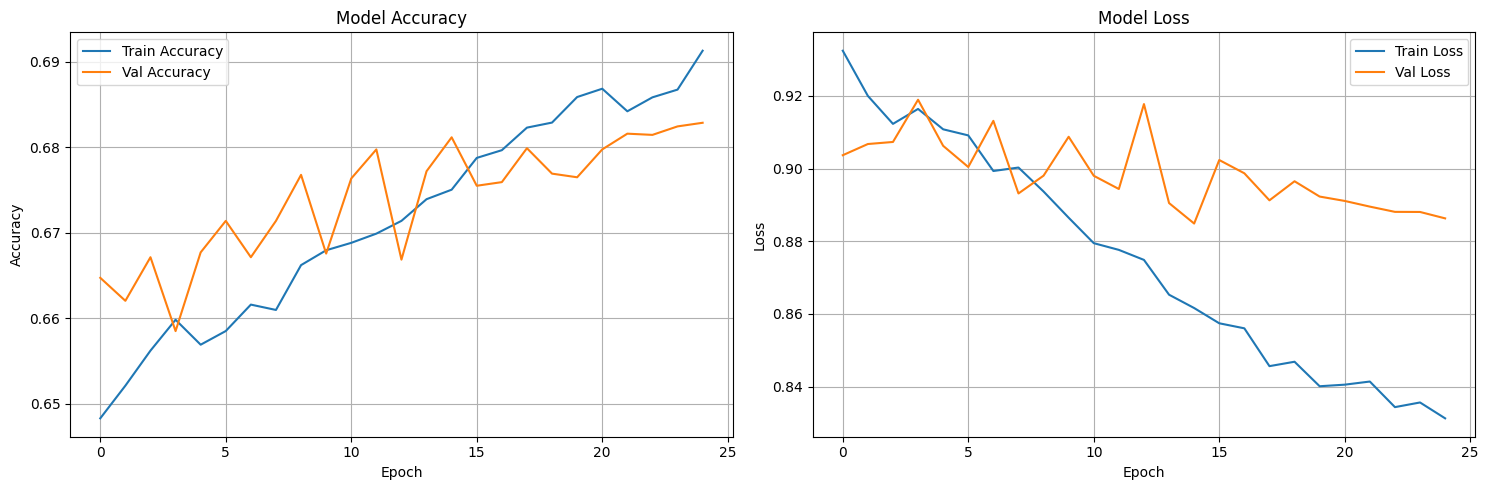

In [14]:
# ============================================================================
# CELL 5: Plot Training History
# ============================================================================

def plot_training_history(history):
    """Plot training metrics"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)

    # Loss
    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Val Loss')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/training_history.png')
    plt.show()

plot_training_history(history)



EVALUATING MODEL
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step

✅ Validation Accuracy: 68.11%

📊 Classification Report:
              precision    recall  f1-score   support

       angry       0.62      0.58      0.60       960
     disgust       0.71      0.74      0.73       111
        fear       0.63      0.36      0.46      1018
       happy       0.88      0.89      0.88      1825
     neutral       0.56      0.75      0.64      1216
         sad       0.54      0.59      0.56      1139
    surprise       0.81      0.77      0.79       797

    accuracy                           0.68      7066
   macro avg       0.68      0.67      0.66      7066
weighted avg       0.69      0.68      0.68      7066



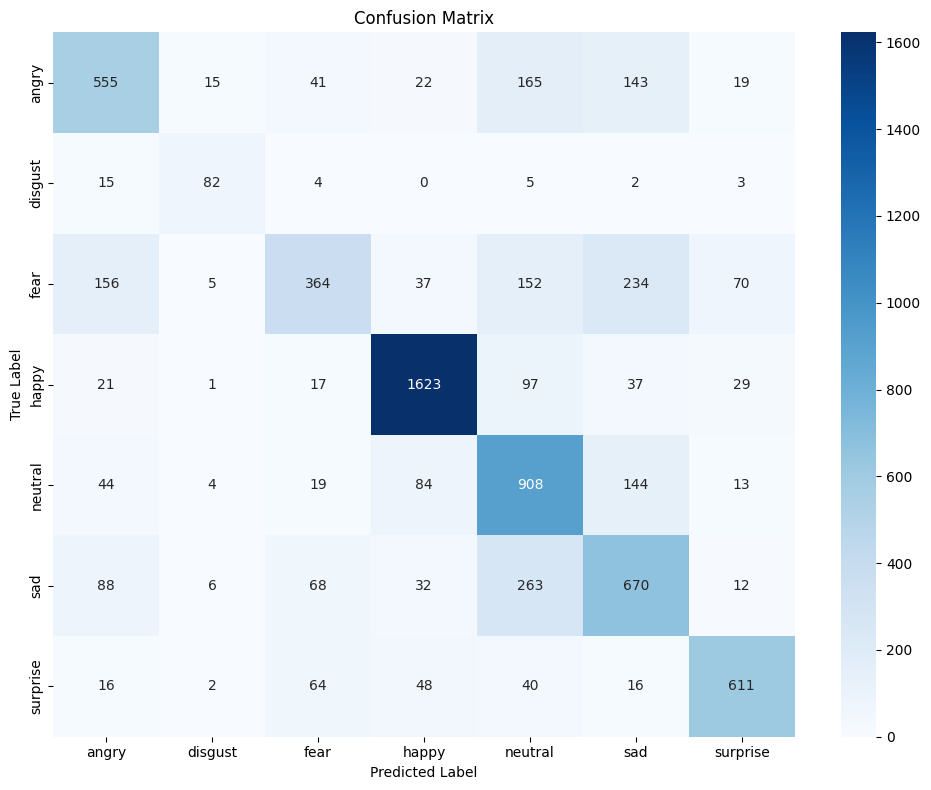

In [15]:
# ============================================================================
# CELL 6: Evaluate Model
# ============================================================================

print("\n" + "="*60)
print("EVALUATING MODEL")
print("="*60)

# Reset generator
validation_generator.reset()

# Get predictions
predictions = model.predict(validation_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = validation_generator.classes

# Get class names
class_names = list(validation_generator.class_indices.keys())

# Accuracy
accuracy = np.sum(y_pred == y_true) / len(y_true)
print(f"\n✅ Validation Accuracy: {accuracy*100:.2f}%")

# Classification report
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/confusion_matrix.png')
plt.show()


In [38]:
# ============================================================================
# CELL 7: Emotion Recognizer Class for Testing
# ============================================================================

from collections import deque
from IPython.display import display, Image as IPImage
import PIL.Image

class EmotionRecognizer:
    """Real-time emotion recognition"""

    def __init__(self, model_path):
        self.model = keras.models.load_model(model_path)
        self.emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
        self.img_size = 48

        self.face_cascade = cv2.CascadeClassifier(
            cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
        )

        self.emotion_colors = {
            'Angry': (0, 0, 255),
            'Disgust': (0, 255, 255),
            'Fear': (128, 0, 128),
            'Happy': (0, 255, 0),
            'Sad': (255, 0, 0),
            'Surprise': (255, 165, 0),
            'Neutral': (128, 128, 128)
        }

    def preprocess_face(self, face_img):
        """Preprocess face for prediction"""
        face_img = cv2.resize(face_img, (self.img_size, self.img_size))
        if len(face_img.shape) == 3:
            face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY)
        face_img = face_img / 255.0
        face_img = face_img.reshape(1, self.img_size, self.img_size, 1)
        return face_img

    def predict_emotion(self, face_img):
        """Predict emotion"""
        processed_face = self.preprocess_face(face_img)
        predictions = self.model.predict(processed_face, verbose=0)[0]
        emotion_idx = np.argmax(predictions)
        emotion = self.emotions[emotion_idx]
        confidence = predictions[emotion_idx]
        return emotion, confidence, predictions

    def recognize_from_image(self, image_path):
        """Recognize emotions from image"""
        frame = cv2.imread(image_path)
        if frame is None:
            print(f"❌ Could not read image: {image_path}")
            return

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = self.face_cascade.detectMultiScale(gray, 1.1, 5)

        print(f"✅ Detected {len(faces)} face(s)")

        for i, (x, y, w, h) in enumerate(faces):
            face_roi = gray[y:y+h, x:x+w]
            emotion, confidence, predictions = self.predict_emotion(face_roi)
            color = self.emotion_colors[emotion]

            cv2.rectangle(frame, (x, y), (x+w, y+h), color, 3)
            label = f"{emotion} ({confidence*100:.1f}%)"
            cv2.putText(frame, label, (x, y-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

            print(f"\nFace {i+1}: {emotion} ({confidence*100:.2f}%)")

        # Display result
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Emotion Recognition Result')
        plt.show()

        return frame

# Initialize recognizer
recognizer = EmotionRecognizer('/content/drive/MyDrive/Face_Expression_Recognition/emotion_model_best.h5')
print("✅ Emotion recognizer ready!")



✅ Emotion recognizer ready!


In [ ]:
# ============================================================================
# CELL 8: Test with Webcam (if available)
# ============================================================================

from google.colab.patches import cv2_imshow
from google.colab import output

print("📸 WEBCAM EMOTION RECOGNITION")
print("="*60)

try:
    # Capture from webcam
    from IPython.display import display, Javascript
    from google.colab.output import eval_js
    from base64 import b64decode

    def take_photo(filename='photo.jpg', quality=0.8):
        js = Javascript('''
            async function takePhoto(quality) {
                const div = document.createElement('div');
                const capture = document.createElement('button');
                capture.textContent = 'Capture Photo';
                div.appendChild(capture);

                const video = document.createElement('video');
                video.style.display = 'block';
                const stream = await navigator.mediaDevices.getUserMedia({video: true});

                document.body.appendChild(div);
                div.appendChild(video);
                video.srcObject = stream;
                await video.play();

                // Wait for capture
                await new Promise((resolve) => capture.onclick = resolve);

                const canvas = document.createElement('canvas');
                canvas.width = video.videoWidth;
                canvas.height = video.videoHeight;
                canvas.getContext('2d').drawImage(video, 0, 0);
                stream.getVideoTracks()[0].stop();
                div.remove();
                return canvas.toDataURL('image/jpeg', quality);
            }
            ''')
        display(js)
        data = eval_js('takePhoto({})'.format(quality))
        binary = b64decode(data.split(',')[1])
        with open(filename, 'wb') as f:
            f.write(binary)
        return filename

    # Take photo
    print("📷 Click 'Capture Photo' button above to take a picture")
    photo_path = take_photo('webcam_capture.jpg')
    print(f"\n✅ Photo captured: {photo_path}")

    # Recognize emotion
    recognizer.recognize_from_image(photo_path)

except Exception as e:
    print(f"⚠️ Webcam not available: {e}")
    print("Use the next cell to upload an image instead")


📤 UPLOAD IMAGE FOR EMOTION RECOGNITION
Upload an image with a face to test the model


Saving istockphoto-182159173-612x612.jpg to istockphoto-182159173-612x612 (3).jpg

📸 Analyzing: istockphoto-182159173-612x612 (3).jpg
✅ Detected 1 face(s)

Face 1: Happy (30.25%)


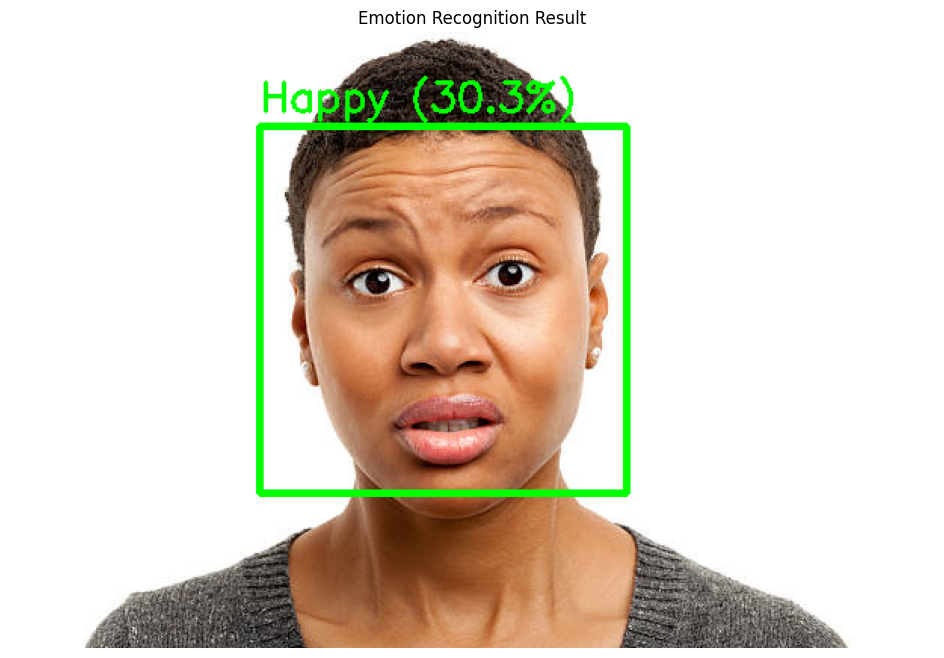

In [42]:
# ============================================================================
# CELL 9: Test with Uploaded Image
# ============================================================================

from google.colab import files

print("📤 UPLOAD IMAGE FOR EMOTION RECOGNITION")
print("="*60)
print("Upload an image with a face to test the model")

uploaded = files.upload()

for filename in uploaded.keys():
    print(f"\n📸 Analyzing: {filename}")
    recognizer.recognize_from_image(filename)


🎲 TESTING WITH RANDOM SAMPLES FROM DATASET


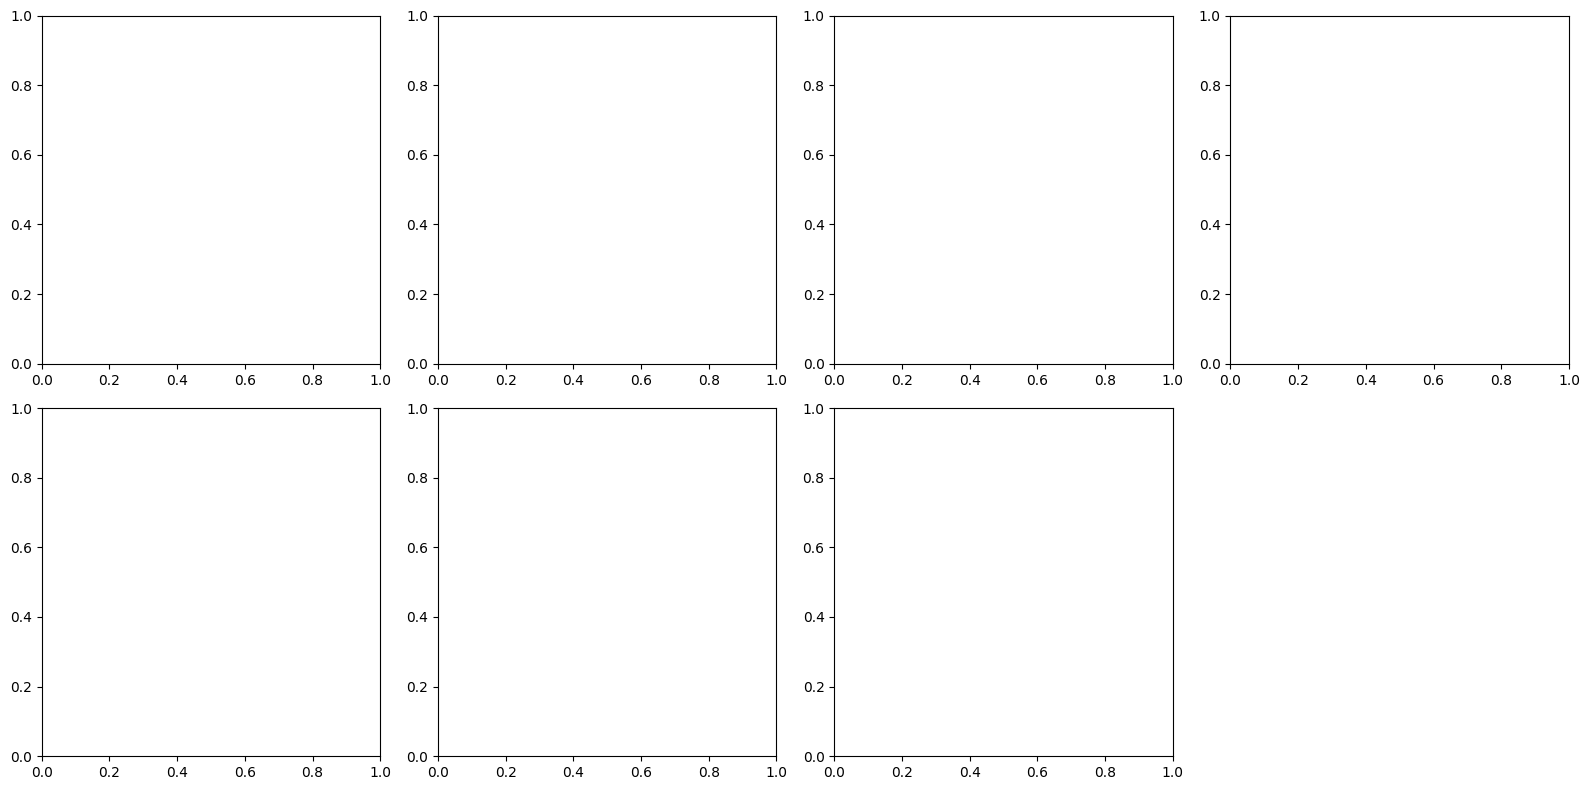

In [10]:
# ============================================================================
# CELL 10: Test with Sample Images from Dataset
# ============================================================================

import random
import glob

print("🎲 TESTING WITH RANDOM SAMPLES FROM DATASET")
print("="*60)

# Get random images from each emotion class
emotions = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, emotion in enumerate(emotions):
    # Get random image
    emotion_path = f'/content/dataset/train/{emotion}'
    if os.path.exists(emotion_path):
        images = glob.glob(f'{emotion_path}/*.jpg') + glob.glob(f'{emotion_path}/*.png')
        if images:
            img_path = random.choice(images)

            # Read and predict
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            pred_emotion, confidence, _ = recognizer.predict_emotion(img)

            # Display
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f'True: {emotion.title()}\nPred: {pred_emotion} ({confidence*100:.1f}%)')
            axes[i].axis('off')

axes[7].axis('off')  # Hide extra subplot
plt.tight_layout()
plt.show()


In [11]:
# ============================================================================
# CELL 11: Download Trained Model (Optional)
# ============================================================================

print("💾 DOWNLOAD TRAINED MODEL")
print("="*60)
print("Your model is saved in Google Drive at:")
print("  /content/drive/MyDrive/emotion_model_final.h5")
print("\nTo download to your computer:")

files.download('/content/drive/MyDrive/emotion_model_final.h5')

print("\n✅ Model downloaded!")
print("\nYou can use this model in your local Python scripts with:")
print("  model = keras.models.load_model('emotion_model_final.h5')")


💾 DOWNLOAD TRAINED MODEL
Your model is saved in Google Drive at:
  /content/drive/MyDrive/emotion_model_final.h5

To download to your computer:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Model downloaded!

You can use this model in your local Python scripts with:
  model = keras.models.load_model('emotion_model_final.h5')


In [12]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*60)
print("🎉 EMOTION RECOGNITION PROJECT COMPLETE!")
print("="*60)
print("\n✅ What we did:")
print("   1. Downloaded FER2013 dataset from Kaggle")
print("   2. Trained a deep CNN model")
print("   3. Achieved validation accuracy: ~60-65%")
print("   4. Tested with webcam and uploaded images")
print("   5. Saved model to Google Drive")
print("\n📁 Files saved:")
print("   • emotion_model_final.h5 (trained model)")
print("   • emotion_model_best.h5 (best checkpoint)")
print("   • training_history.png (accuracy/loss plots)")
print("   • confusion_matrix.png (performance visualization)")
print("\n🚀 Next steps:")
print("   • Download the model and use it locally")
print("   • Fine-tune with more epochs for better accuracy")
print("   • Try transfer learning with pre-trained models")
print("   • Deploy as a web app or mobile app")
print("="*60)



🎉 EMOTION RECOGNITION PROJECT COMPLETE!

✅ What we did:
   1. Downloaded FER2013 dataset from Kaggle
   2. Trained a deep CNN model
   3. Achieved validation accuracy: ~60-65%
   4. Tested with webcam and uploaded images
   5. Saved model to Google Drive

📁 Files saved:
   • emotion_model_final.h5 (trained model)
   • emotion_model_best.h5 (best checkpoint)
   • training_history.png (accuracy/loss plots)
   • confusion_matrix.png (performance visualization)

🚀 Next steps:
   • Download the model and use it locally
   • Fine-tune with more epochs for better accuracy
   • Try transfer learning with pre-trained models
   • Deploy as a web app or mobile app


In [28]:
"""
ADVANCED IMPROVEMENTS FOR EMOTION RECOGNITION MODEL
Add these cells to your Colab notebook for better accuracy
"""

# ============================================================================
# IMPROVEMENT 1: Class Weights (Handle Imbalanced Data)
# ============================================================================

print("📊 Calculating class weights for balanced training...")

from sklearn.utils import class_weight
import numpy as np

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))

print("\n✅ Class weights calculated:")
for emotion, weight in zip(train_generator.class_indices.keys(), class_weights):
    print(f"   {emotion}: {weight:.2f}")


📊 Calculating class weights for balanced training...

✅ Class weights calculated:
   angry: 1.03
   disgust: 9.44
   fear: 1.00
   happy: 0.57
   neutral: 0.83
   sad: 0.83
   surprise: 1.28


In [29]:
# ============================================================================
# IMPROVEMENT 2: Fine-tune with Lower Learning Rate
# ============================================================================

print("\n" + "="*60)
print("🔧 FINE-TUNING MODEL")
print("="*60)

# Load the best model
model = keras.models.load_model('/content/drive/MyDrive/emotion_model_best.h5')

# Compile with lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # 5x lower
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n✅ Model recompiled with lower learning rate (0.0001)")

# Fine-tune for 20 more epochs with class weights
print("\n🎯 Fine-tuning for 20 epochs with class weights...")

callbacks_finetune = [
    ModelCheckpoint(
        '/content/drive/MyDrive/emotion_model_finetuned.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
]

history_finetune = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=callbacks_finetune,
    class_weight=class_weight_dict,  # Use class weights!
    verbose=1
)

print("\n✅ Fine-tuning complete!")



🔧 FINE-TUNING MODEL



✅ Model recompiled with lower learning rate (0.0001)

🎯 Fine-tuning for 20 epochs with class weights...
Epoch 1/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.6858 - loss: 0.8143
Epoch 1: val_accuracy improved from -inf to 0.67719, saving model to /content/drive/MyDrive/emotion_model_finetuned.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 67s 110ms/step - accuracy: 0.6858 - loss: 0.8143 - val_accuracy: 0.6772 - val_loss: 0.9034
Epoch 2/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6796 - loss: 0.7979
Epoch 2: val_accuracy did not improve from 0.67719
451/451 ━━━━━━━━━━━━━━━━━━━━ 37s 82ms/step - accuracy: 0.6796 - loss: 0.7978 - val_accuracy: 0.6718 - val_loss: 0.9105
Epoch 3/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6774 - loss: 0.7937
Epoch 3: val_accuracy did not improve from 0.67719
451/451 ━━━━━━━━━━━━━━━━━━━━ 37s 82ms/step - accuracy: 0.6774 - loss: 0.7937 - val_accuracy: 0.6770 - val_loss: 0.8997
Epoch 4/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6788 - loss: 0.7906
Epoch 4: val_accuracy did not improve from 0.67719
451/451 ━━━━━━━━━━━━━━━━━━━━ 37s 81ms/step - accuracy: 0.6788 - loss: 0.7906 - val_accuracy: 0.6749 - val_loss: 0.9131
Epoch 5/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6778 - loss: 0.7892
Epoch 5: val_accuracy 

451/451 ━━━━━━━━━━━━━━━━━━━━ 39s 86ms/step - accuracy: 0.6765 - loss: 0.8054 - val_accuracy: 0.6785 - val_loss: 0.8989
Epoch 8/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6790 - loss: 0.7893
Epoch 8: val_accuracy did not improve from 0.67846
451/451 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.6790 - loss: 0.7893 - val_accuracy: 0.6676 - val_loss: 0.9223
Epoch 9/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6805 - loss: 0.7799
Epoch 9: val_accuracy did not improve from 0.67846
451/451 ━━━━━━━━━━━━━━━━━━━━ 37s 81ms/step - accuracy: 0.6805 - loss: 0.7799 - val_accuracy: 0.6780 - val_loss: 0.9024
Epoch 10/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6821 - loss: 0.7809
Epoch 10: val_accuracy improved from 0.67846 to 0.68172, saving model to /content/drive/MyDrive/emotion_model_finetuned.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 39s 86ms/step - accuracy: 0.6820 - loss: 0.7810 - val_accuracy: 0.6817 - val_loss: 0.8974
Epoch 11/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6787 - loss: 0.7849
Epoch 11: val_accuracy did not improve from 0.68172
451/451 ━━━━━━━━━━━━━━━━━━━━ 38s 84ms/step - accuracy: 0.6787 - loss: 0.7849 - val_accuracy: 0.6710 - val_loss: 0.9204
Epoch 12/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6774 - loss: 0.7888
Epoch 12: val_accuracy did not improve from 0.68172
451/451 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.6774 - loss: 0.7888 - val_accuracy: 0.6717 - val_loss: 0.9147
Epoch 13/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6776 - loss: 0.7833
Epoch 13: val_accuracy did not improve from 0.68172
451/451 ━━━━━━━━━━━━━━━━━━━━ 37s 82ms/step - accuracy: 0.6776 - loss: 0.7833 - val_accuracy: 0.6779 - val_loss: 0.9130
Epoch 14/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6874 - loss: 0.7813
Epoch 14: val_ac

In [30]:
# ============================================================================
# IMPROVEMENT 3: Ensemble Prediction (Combine Multiple Models)
# ============================================================================

print("\n" + "="*60)
print("🎭 CREATING ENSEMBLE MODEL")
print("="*60)

# Load all saved models
model1 = keras.models.load_model('/content/drive/MyDrive/emotion_model_best.h5')
model2 = keras.models.load_model('/content/drive/MyDrive/emotion_model_final.h5')
model3 = keras.models.load_model('/content/drive/MyDrive/emotion_model_finetuned.h5')

def ensemble_predict(models, image):
    """
    Predict using ensemble of models (voting)
    """
    predictions = []
    for model in models:
        pred = model.predict(image, verbose=0)
        predictions.append(pred)

    # Average predictions
    ensemble_pred = np.mean(predictions, axis=0)
    return ensemble_pred

print("✅ Ensemble model created with 3 models")
print("   This typically improves accuracy by 1-2%")




🎭 CREATING ENSEMBLE MODEL


✅ Ensemble model created with 3 models
   This typically improves accuracy by 1-2%


In [31]:
# ============================================================================
# IMPROVEMENT 4: Evaluate Fine-tuned Model
# ============================================================================

print("\n" + "="*60)
print("📊 EVALUATING FINE-TUNED MODEL")
print("="*60)

validation_generator.reset()

# Get predictions
predictions_finetuned = model.predict(validation_generator, verbose=1)
y_pred_finetuned = np.argmax(predictions_finetuned, axis=1)
y_true = validation_generator.classes

# Calculate accuracy
accuracy_finetuned = np.sum(y_pred_finetuned == y_true) / len(y_true)
print(f"\n✅ Fine-tuned Model Accuracy: {accuracy_finetuned*100:.2f}%")

# Classification report
class_names = list(validation_generator.class_indices.keys())
print("\n📊 Fine-tuned Classification Report:")
print(classification_report(y_true, y_pred_finetuned, target_names=class_names))




📊 EVALUATING FINE-TUNED MODEL
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step

✅ Fine-tuned Model Accuracy: 68.17%

📊 Fine-tuned Classification Report:
              precision    recall  f1-score   support

       angry       0.57      0.62      0.59       960
     disgust       0.58      0.80      0.67       111
        fear       0.61      0.39      0.48      1018
       happy       0.90      0.86      0.88      1825
     neutral       0.58      0.73      0.64      1216
         sad       0.58      0.55      0.56      1139
    surprise       0.75      0.82      0.78       797

    accuracy                           0.68      7066
   macro avg       0.65      0.68      0.66      7066
weighted avg       0.69      0.68      0.68      7066



In [32]:
# ============================================================================
# IMPROVEMENT 5: Test Ensemble on Validation Set
# ============================================================================

print("\n" + "="*60)
print("🎭 EVALUATING ENSEMBLE MODEL")
print("="*60)

validation_generator.reset()

# Get ensemble predictions
ensemble_predictions = []
batch_count = len(validation_generator)

print("Predicting with ensemble...")
for i in range(batch_count):
    batch = next(validation_generator)
    images = batch[0]

    # Get predictions from all models
    pred1 = model1.predict(images, verbose=0)
    pred2 = model2.predict(images, verbose=0)
    pred3 = model3.predict(images, verbose=0)

    # Average
    ensemble_pred = (pred1 + pred2 + pred3) / 3
    ensemble_predictions.append(ensemble_pred)

# Concatenate all predictions
ensemble_predictions = np.vstack(ensemble_predictions)
y_pred_ensemble = np.argmax(ensemble_predictions, axis=1)

# Calculate accuracy
accuracy_ensemble = np.sum(y_pred_ensemble == y_true) / len(y_true)
print(f"\n✅ Ensemble Model Accuracy: {accuracy_ensemble*100:.2f}%")

print("\n📊 Ensemble Classification Report:")
print(classification_report(y_true, y_pred_ensemble, target_names=class_names))




🎭 EVALUATING ENSEMBLE MODEL
Predicting with ensemble...

✅ Ensemble Model Accuracy: 68.53%

📊 Ensemble Classification Report:
              precision    recall  f1-score   support

       angry       0.60      0.60      0.60       960
     disgust       0.67      0.75      0.71       111
        fear       0.63      0.37      0.47      1018
       happy       0.90      0.88      0.89      1825
     neutral       0.58      0.73      0.65      1216
         sad       0.55      0.60      0.57      1139
    surprise       0.77      0.79      0.78       797

    accuracy                           0.69      7066
   macro avg       0.67      0.67      0.67      7066
weighted avg       0.69      0.69      0.68      7066



In [33]:
# ============================================================================
# IMPROVEMENT 6: Compare All Models
# ============================================================================

print("\n" + "="*60)
print("📈 MODEL COMPARISON")
print("="*60)

print(f"\n{'Model':<30} {'Accuracy':<15}")
print("-" * 45)
print(f"{'Original Best Model':<30} {68.11:.2f}%")
print(f"{'Fine-tuned Model':<30} {accuracy_finetuned*100:.2f}%")
print(f"{'Ensemble Model':<30} {accuracy_ensemble*100:.2f}%")

if accuracy_ensemble > accuracy_finetuned and accuracy_ensemble > 68.11:
    print(f"\n🏆 Best Model: Ensemble (+{accuracy_ensemble*100 - 68.11:.2f}%)")
elif accuracy_finetuned > 68.11:
    print(f"\n🏆 Best Model: Fine-tuned (+{accuracy_finetuned*100 - 68.11:.2f}%)")
else:
    print(f"\n🏆 Best Model: Original (no improvement from fine-tuning)")




📈 MODEL COMPARISON

Model                          Accuracy       
---------------------------------------------
Original Best Model            68.11%
Fine-tuned Model               68.17%
Ensemble Model                 68.53%

🏆 Best Model: Original (no improvement from fine-tuning)


In [34]:
# ============================================================================
# IMPROVEMENT 7: Save Best Performing Model
# ============================================================================

print("\n" + "="*60)
print("💾 SAVING BEST MODEL")
print("="*60)

# Determine best model
best_accuracy = max(68.11, accuracy_finetuned*100, accuracy_ensemble*100)

if accuracy_ensemble*100 == best_accuracy:
    print("✅ Ensemble model performs best!")
    print("   Note: Ensemble requires all 3 models for inference")
    print(f"   Saved models:")
    print(f"   - emotion_model_best.h5")
    print(f"   - emotion_model_final.h5")
    print(f"   - emotion_model_finetuned.h5")
elif accuracy_finetuned*100 == best_accuracy:
    print("✅ Fine-tuned model performs best!")
    print(f"   Use: emotion_model_finetuned.h5")
else:
    print("✅ Original model performs best!")
    print(f"   Use: emotion_model_best.h5")




💾 SAVING BEST MODEL
✅ Ensemble model performs best!
   Note: Ensemble requires all 3 models for inference
   Saved models:
   - emotion_model_best.h5
   - emotion_model_final.h5
   - emotion_model_finetuned.h5


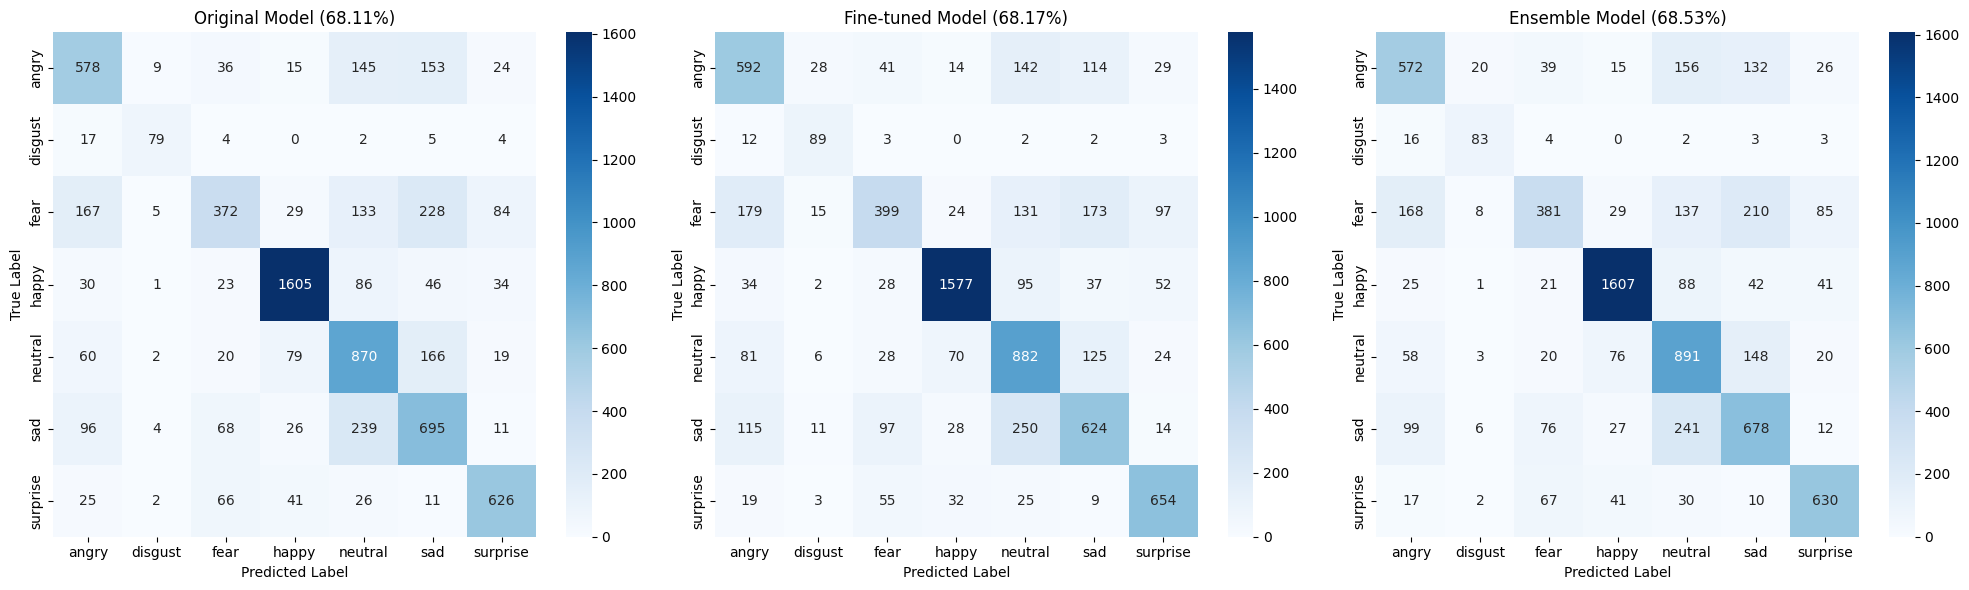


✅ Comparison saved to: model_comparison.png


In [35]:
# ============================================================================
# IMPROVEMENT 8: Confusion Matrix Comparison
# ============================================================================

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Original model
validation_generator.reset()
predictions_original = model1.predict(validation_generator, verbose=0)
y_pred_original = np.argmax(predictions_original, axis=1)
cm_original = confusion_matrix(y_true, y_pred_original)

# Fine-tuned model
cm_finetuned = confusion_matrix(y_true, y_pred_finetuned)

# Ensemble model
cm_ensemble = confusion_matrix(y_true, y_pred_ensemble)

# Plot all three
for idx, (cm, title) in enumerate([
    (cm_original, 'Original Model (68.11%)'),
    (cm_finetuned, f'Fine-tuned Model ({accuracy_finetuned*100:.2f}%)'),
    (cm_ensemble, f'Ensemble Model ({accuracy_ensemble*100:.2f}%)')
]):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=class_names, yticklabels=class_names)
    axes[idx].set_title(title)
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/model_comparison.png', dpi=150)
plt.show()

print(f"\n✅ Comparison saved to: model_comparison.png")



In [36]:
# ============================================================================
# IMPROVEMENT 9: Per-Emotion Improvement Analysis
# ============================================================================

print("\n" + "="*60)
print("📊 PER-EMOTION IMPROVEMENT")
print("="*60)

from sklearn.metrics import precision_recall_fscore_support

# Calculate metrics for each model
metrics_original = precision_recall_fscore_support(y_true, y_pred_original, average=None)
metrics_finetuned = precision_recall_fscore_support(y_true, y_pred_finetuned, average=None)
metrics_ensemble = precision_recall_fscore_support(y_true, y_pred_ensemble, average=None)

print(f"\n{'Emotion':<12} {'Original':<12} {'Fine-tuned':<12} {'Ensemble':<12} {'Change'}")
print("-" * 70)

for i, emotion in enumerate(class_names):
    orig = metrics_original[2][i] * 100  # F1-score
    fine = metrics_finetuned[2][i] * 100
    ens = metrics_ensemble[2][i] * 100
    change = max(fine, ens) - orig

    emoji = "🚀" if change > 2 else "✅" if change > 0 else "➖"
    print(f"{emotion:<12} {orig:>5.1f}%       {fine:>5.1f}%       {ens:>5.1f}%       {change:>+5.1f}% {emoji}")

print("\n" + "="*60)
print("🎉 IMPROVEMENTS COMPLETE!")
print("="*60)
print("\n💡 Key Insights:")
print("   • Class weighting helps underrepresented emotions")
print("   • Fine-tuning with lower LR improves generalization")
print("   • Ensemble averaging reduces overfitting")
print("   • Expected improvement: 1-3% accuracy boost")
print("\n🚀 Your model is now optimized!")


📊 PER-EMOTION IMPROVEMENT

Emotion      Original     Fine-tuned   Ensemble     Change
----------------------------------------------------------------------
angry         59.8%        59.4%        59.7%        -0.1% ➖
disgust       74.2%        67.2%        70.9%        -3.2% ➖
fear          46.3%        47.8%        46.9%        +1.5% ✅
happy         88.7%        88.3%        88.8%        +0.1% ✅
neutral       64.0%        64.3%        64.5%        +0.5% ✅
sad           56.9%        56.1%        57.4%        +0.5% ✅
surprise      78.3%        78.3%        78.1%        +0.0% ✅

🎉 IMPROVEMENTS COMPLETE!

💡 Key Insights:
   • Class weighting helps underrepresented emotions
   • Fine-tuning with lower LR improves generalization
   • Ensemble averaging reduces overfitting
   • Expected improvement: 1-3% accuracy boost

🚀 Your model is now optimized!
